In [1]:
import pandas as pd 
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use('seaborn')

#getting the data
df1 = pd.read_csv("new-533_1 (GE).csv")
df2 = pd.read_csv("new-534_1 (GE).csv")
df3 = pd.read_csv("V300032999_L3_HK500PLAvzqEAAIRAAPEI-535_1 (GE).csv")

df4 = pd.read_csv("V300029980_L3_HK500PLAvzqEAAARBAPEI-594_1 (GE).csv")
df5 = pd.read_csv("V300029980_L3_HK500PLAvzqEAABRBAPEI-595_1 (GE).csv")
df6 = pd.read_csv("V300032999_L3_HK500PLAvzqEAACRAAPEI-529_1 (GE).csv")

#slicing the dataframes to get only names and TPM values and setting the name as the index
def slice_and_dice(df,name):
    newdf = df.loc[:,["Name","TPM"]]
    newdf = newdf.set_index("Name")
    newdf.rename(columns={"TPM":name},inplace =True)
    return newdf

ko1 = slice_and_dice(df1,"ko1")
ko2 = slice_and_dice(df2,"ko2")
ko3 = slice_and_dice(df3,"ko3")

wt1 = slice_and_dice(df4,"wt1")
wt2 = slice_and_dice(df5,"wt2")
wt3 = slice_and_dice(df6,"wt3")

print (wt1.head())

               wt1
Name              
OR4F5     0.000000
OR4F29    0.000000
OR4F16    0.000000
SAMD11    6.816732
NOC2L   168.954106


In [2]:
#Merging time (inner merge, only those that have 2 of them!) - I hated this code, there should be another way ?
data = pd.merge(wt1, wt2, left_index=True, right_index=True)
data = pd.merge(data,wt3,left_index=True, right_index=True)
temp_data = pd.merge(ko1,ko2,left_index=True, right_index=True)
data = pd.merge(data,temp_data,left_index=True, right_index=True)
data = pd.merge(data,ko3,left_index=True, right_index=True)

x, y = data.shape
print(x)

#getting rid of genes that counted 0 (for all samples!)
data["sum"] = data["wt1"] + data["wt2"] + data["wt3"] + data["ko1"] + data["ko2"] + data["ko3"]
data = data.loc[data["sum"] != 0]
del data["sum"]

x, y = data.shape
print(x)

print(data.head())

21486
17021
                wt1         wt2         wt3         ko1         ko2  \
Name                                                                  
OR4F29     0.000000    0.177373    0.151052    0.164572    0.000000   
SAMD11     6.816732    5.748731   10.029313   11.445544    9.705910   
NOC2L    168.954106  179.060069  176.734595  161.674257  144.185925   
KLHL17    28.794226   32.311971   47.988202   30.706806   30.001990   
PLEKHN1    4.048170    4.536665    5.466384    2.955434    2.856523   

                ko3  
Name                 
OR4F29     0.000000  
SAMD11     6.047284  
NOC2L    177.033294  
KLHL17    27.851240  
PLEKHN1    2.491058  


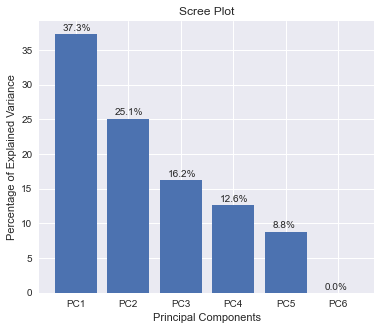

In [3]:
#avg value of genes are 0 and the sd is 1, now their eukladiand distance gives 1
scaled_data = preprocessing.scale(data.T)

#now we create an empty PCA object
pca = PCA()

#put our scaled data into this (only mathematical part)
pca.fit(scaled_data)

#generate coordinates for the data (for visualization) 
pca_data =pca.transform(scaled_data)

#calculates the variance for each Principal Component and rounds them up (in percentage)
per_var = np.round(pca.explained_variance_ratio_*100,decimals=1)

#these are just for scree plot

labels = ["PC"+str(i) for i in range (1,len(per_var)+1)]


fig = plt.figure(figsize =[6, 5])
plt.bar(x=range(1, len(per_var)+1), height = per_var,tick_label =labels )

for i, v in enumerate(per_var):
    plt.text(i+1 - 0.25, v + 0.5, (str(v)+ '%'))
    
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title("Scree Plot")
plt.show()

#fig.savefig("scree_PATZ1.jpg",dpi =200)

In [4]:
wt = ["wt" + str(i) for i in range (1,4)] 
ko = ["ko" + str(i) for i in range (1,4)] 

#now to draw the PCA plot itself
#create a new dataframe to have the PCA axis (for all PCA 1 to 10)
pca_df = pd.DataFrame(pca_data, index =[*wt, *ko],columns=labels)
pca_df.head(6)

,PC1,PC2,PC3,PC4,PC5,PC6
wt1,-116.030767,34.084208,-44.031837,-32.409901,-46.063549,-4.043293e-14
wt2,-87.939015,40.782154,35.984761,36.631706,58.711001,-9.092033e-14
wt3,117.335737,107.771807,8.123127,-8.586967,-9.270876,7.813195e-14
ko1,35.211821,-53.723847,-37.343464,83.289758,-23.960688,-8.673617e-15
ko2,42.745025,-61.465483,-55.951967,-52.236120,46.116556,2.843906e-14
ko3,8.677200,-67.448839,93.219380,-26.688476,-25.532444,4.138356e-14


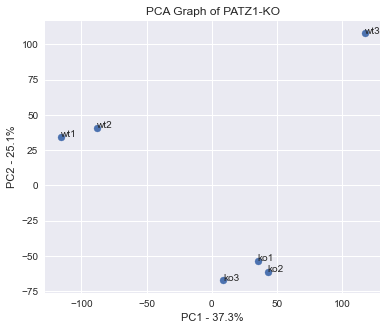

In [13]:
fig1= plt.figure(figsize =[6, 5])
plt.scatter(pca_df["PC1"], pca_df["PC2"])
plt.title("PCA Graph of PATZ1-KO")
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for sample in pca_df.index:
    plt.annotate(sample,(pca_df["PC1"].loc[sample],pca_df["PC2"].loc[sample]))
    
plt.show()

#fig1.savefig("PCA_PATZ1.jpg",dpi =200)

In [12]:
#loading score
loading_scores = pd.Series(pca.components_[0], index=data.index)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

top_50 = sorted_loading_scores[0:50].index.values
display(loading_scores[top_50])

#saving
#pd.DataFrame(top_50).to_csv("top_50_from_PATZ1.csv",index = None, header =None)

Name
RNGTT                  -0.012546
EXD2                   -0.012533
ARFIP1                 -0.012531
AGPS                   -0.012521
KLHL23                 -0.012521
CCNC                   -0.012519
CLCN3                  -0.012518
RNF139                 -0.012518
RCBTB1                 -0.012514
RAB10                  -0.012514
MORC3                  -0.012512
NEK4                   -0.012512
SOWAHC                 -0.012512
IKZF5                  -0.012511
HACD3                  -0.012511
MAP4K3                 -0.012508
TM9SF2                 -0.012507
CLPX                   -0.012504
SARAF                  -0.012503
ATF1                   -0.012502
MTDH                   -0.012501
SETD2                  -0.012501
CAMSAP2                -0.012500
TEX10                  -0.012499
YWHAZ                  -0.012497
STK26                  -0.012496
TCEA1                  -0.012495
SLC25A30               -0.012494
PEX13                  -0.012494
PALS2                  -0.012494
gene: